# Kernel-based Time-varying Regression (KTR)

Kerenl-based Time-varying Regression 

Complex seasonality is a typical problem in time-series modeling. For example, in daily time-series data, you may expect a weekly and yearly seasonal pattern within your data. Here we introduce a kernel-based time-varying regression (KTR) to model the trend and complex seasonality.
In summary, we will cover:

- KTRLite model structure
- Syntax to call, fit and predict in KTRLite 
- Utilities to check / visualize fitting results

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_electricity_demand

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
print(orbit.__version__)

1.0.16dev


## Model Structure

Our goal is to derive an additive form such that 

$$y_t = l_t + s_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the complex seasonality term.

In our approach, we can re-write the formula as 

$$y_t = X_t^T\beta_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $\beta_t$ is a $P$-dimensional vector of coefficients vary over time,  $X_t$ is a $P$-dimensional covariate, and $\epsilon_t$ is a stationary random error process.

Here we introduce the idea of expressing $\beta$ as such

$$\beta=Kb^T$$

where

- *knot matrix* $b$ with size $P\times M$  where each entry is a latent vairable  $b_{p, m}$ can be viewed as the "knots" from the perspective of spline regression and
$m$ is a time index such that $m \in [s_1,  \cdots, {s_M}]$ is a subset of $[1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times M$ where the $i$th row and $j$th element can be viewed as the noramlied weight $k(t, t_{s_m})/\sum_{m=1}^{M} k(t, t_{s_m})$

For the level/trend,

$$l_t = \beta_{t, \text{lev}}$$

It can also be viewed as a dynamic intercept (where the regressor is a vector of ones).

For the seasonality,

$$\beta_{\text{seas}} = K_{\text{seas}}b^T_{\text{seas}}$$

$$s_t = X_{t, \text{seas}}\beta_{t, \text{seas}}$$


We use Fourier series to handle the seasonality such that seasonality terms can be expressed in a matrix $X_{t, \text{seas}}$.

There are different choices of kernel function (which determines the "design matrix" $K$) and prior for matrix $b$. We don't discuss the details here. 

## Data

To illustrate the usage of KTRLite, we use the daily series of electricity demand in Turkey from year 2000 to year 2008. It is good to model the dual seasonality (weekly and yearly), since it's a daily series.

In [3]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
df[response_col] = np.log(df[response_col])
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [4]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

Split the data into training set and test set.

In [5]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In orbit, we only provide one type of KTRLite model, `KTRLiteMAP`, using Stan as the underlying sampling engine.

Similar to other model types in Orbit, it follows a sklearn style model API. We can create an instance of the Orbit class and then call its fit and predict methods.

Multiple flexible ways are available to control the number of knots in the model. 
* span_level: relative window width between two knots; e.g. `.05` means `20` evenly distributed knots
* level_knot_dates: a list of dates corresponding to the knots.
* level_knot_length: the distance between every two knots.

In [7]:
ktrlite = KTRLite(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=1,
    seed=2021,
    # if you want a uncertainties
    n_bootstrap_draws=1e4,
)

In [8]:
ktrlite.fit(train_df)

Initial log joint probability = -114835
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       2309.71     0.0760474       11546.8      0.5352      0.5352       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       5121.25     0.0136291       318.224           1           1       49   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5136.55    0.00370304       210.612      0.2591           1       72   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5143.12     0.0135881       247.413           1           1       94   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5148.65    0.00352618       151.867       0.413       0.413      118   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [9]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.97374,10.04486,10.11481,10.00524,10.00601,10.00679,0.02494,0.02494,0.02494,0.01392,0.01392,0.01392
1,2008-01-03,9.97581,10.04631,10.11730,10.00448,10.00601,10.00758,0.02704,0.02704,0.02704,0.01326,0.01326,0.01326
2,2008-01-04,9.98936,10.06038,10.13148,10.00371,10.00601,10.00836,0.04170,0.04170,0.04170,0.01267,0.01267,0.01267
3,2008-01-05,9.91790,9.98767,10.05764,10.00295,10.00601,10.00915,-0.03048,-0.03048,-0.03048,0.01214,0.01214,0.01214
4,2008-01-06,9.85979,9.92972,10.00066,10.00218,10.00601,10.00993,-0.08795,-0.08795,-0.08795,0.01167,0.01167,0.01167


## Diagnostic

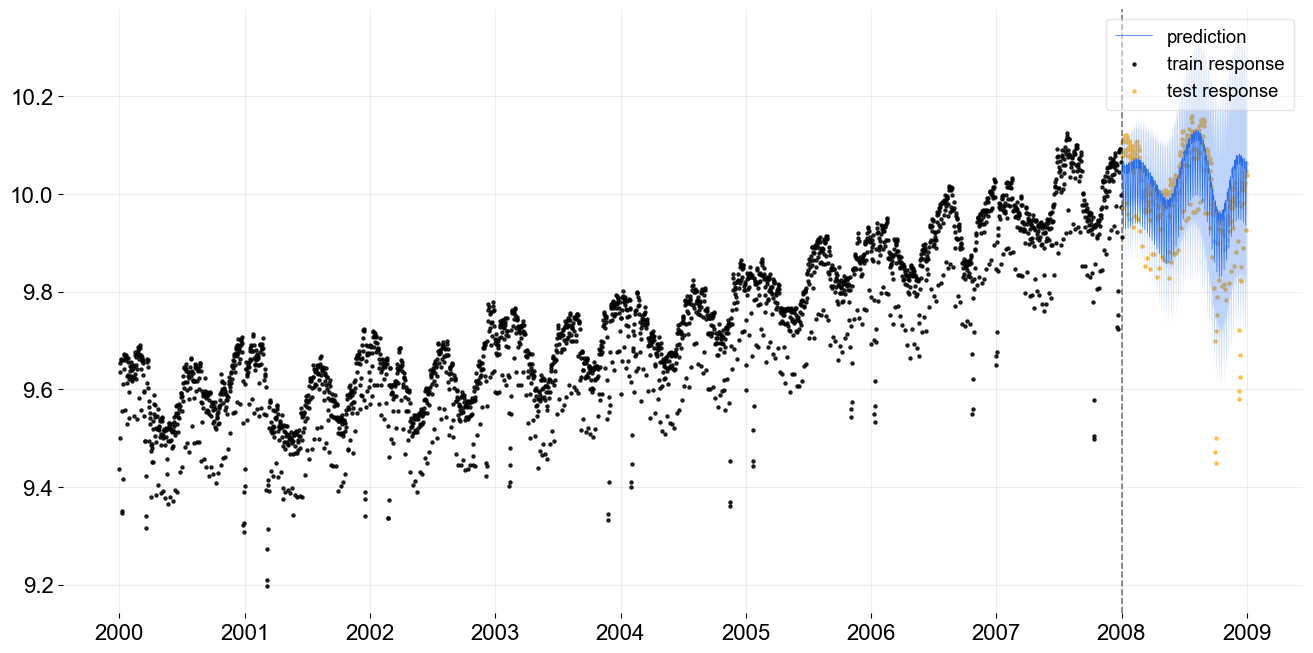

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

In [10]:
'SMAPE:{:.2%}'.format(smape(predicted_df['prediction'].values, test_df['electricity'].values))

'SMAPE:0.51%'

We can use `plot_predicted_components` to visualize each component.

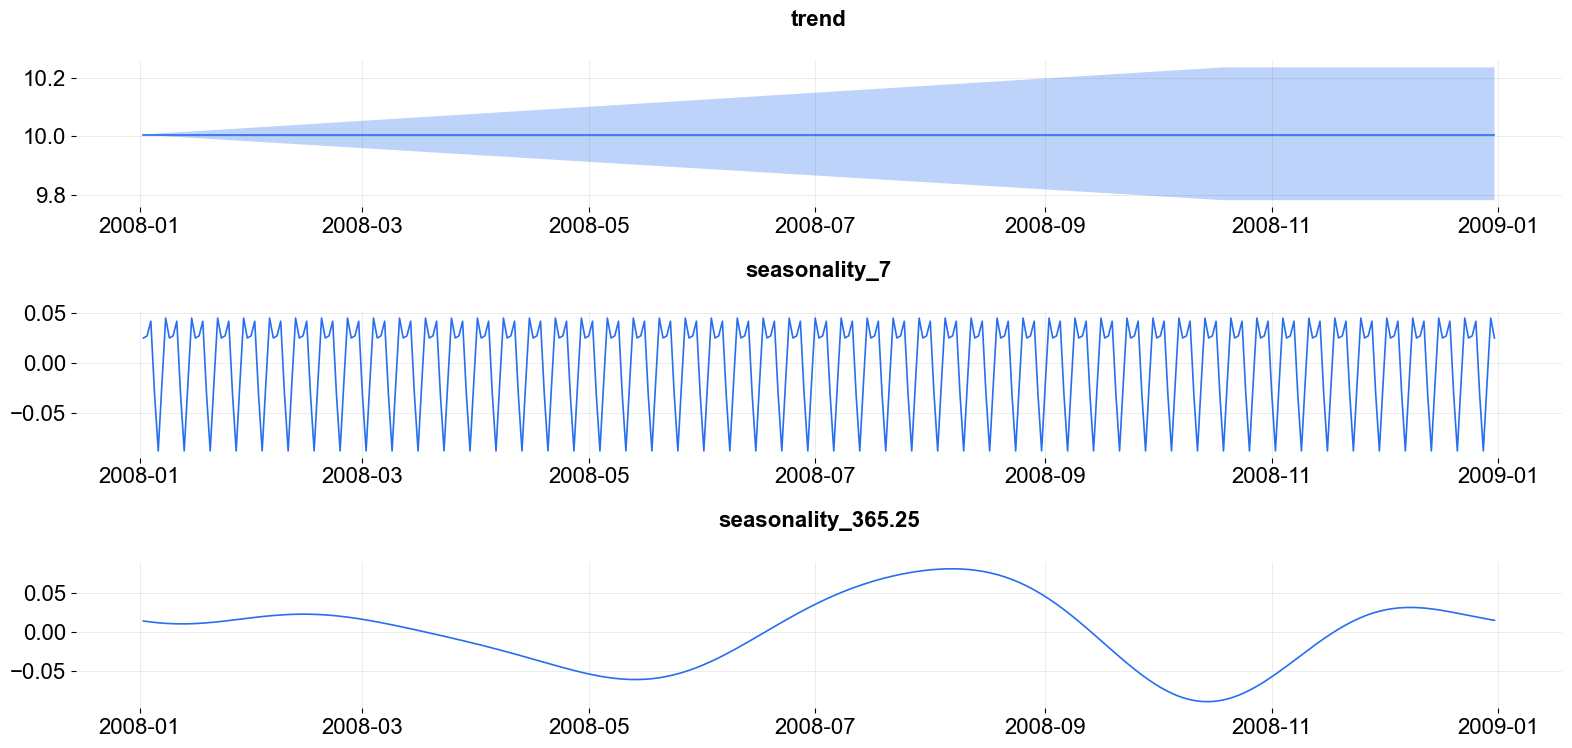

In [11]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

Moreover, we can use `plot_lev_knots` from the object to inspect the shift of the segment divided by the knots.

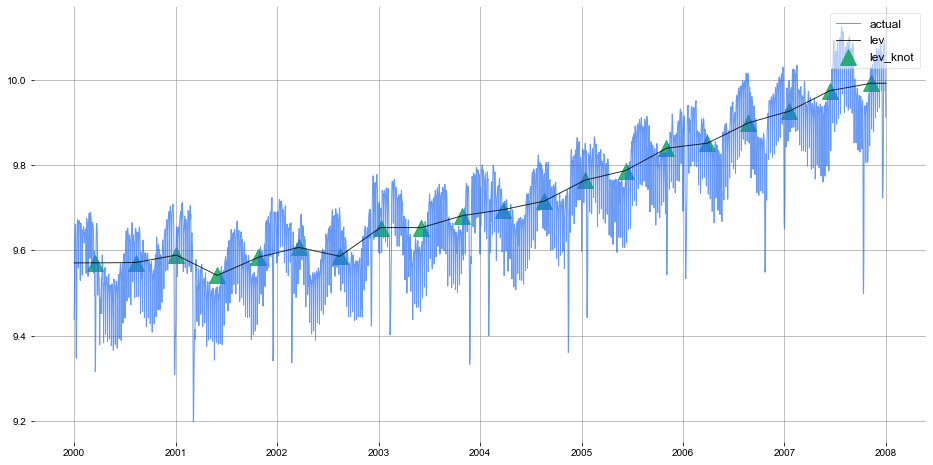

In [12]:
_ = ktrlite.plot_lev_knots()

Some utilies to retreive levels and level knots information.

In [13]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head(5)

,date,lev_knot
0,2000-03-15,9.57082
1,2000-08-09,9.57153
2,2001-01-03,9.58914
3,2001-05-30,9.54148
4,2001-10-24,9.58379


In [14]:
lev_df = ktrlite.get_levels()
lev_df.head(5)

,date,lev
0,2000-01-01,9.57082
1,2000-01-02,9.57082
2,2000-01-03,9.57082
3,2000-01-04,9.57082
4,2000-01-05,9.57082
